In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

Text(0, 0.5, 'Throughput (mb/s)')

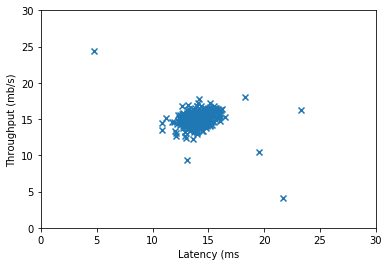

In [3]:
plt.scatter(X[:,0], X[:,1], marker='x')
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('Latency (ms')
plt.ylabel('Throughput (mb/s)')